# Data Owner: upload data

## Install

In [1]:
#!pip install syft

In [2]:
from syft import Worker
import syft as sy
from syft.core.node.new.util import autocache, PANDAS_DATA
worker = Worker.named("pandas-test-domain-4", processes=1, reset=True)
root_domain_client = worker.root_client

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /Users/koen/workspace/PySyft


SQLite Store Path:
!open file:///var/folders/q1/ryq93kwj055dlbpngxv1c7z40000gn/T/7bca415d13ed1ec841f0d0aede098dbb.sqlite

> Starting Worker: test-domain-1 - 7bca415d13ed1ec841f0d0aede098dbb - NodeType.DOMAIN - [<class 'syft.core.node.new.user_service.UserService'>, <class 'syft.core.node.new.metadata_service.MetadataService'>, <class 'syft.core.node.new.action_service.ActionService'>, <class 'syft.core.node.new.test_service.TestService'>, <class 'syft.core.node.new.dataset_service.DatasetService'>, <class 'syft.core.node.new.user_code_service.UserCodeService'>, <class 'syft.core.node.new.request_service.RequestService'>, <class 'syft.core.node.new.data_subject_service.DataSubjectService'>, <class 'syft.core.node.new.network_service.NetworkService'>, <class 'syft.core.node.new.policy_service.PolicyService'>, <class 'syft.core.node.new.message_service.MessageService'>, <class 'syft.core.node.new.project_service.ProjectService'>, <class 'syft.core.node.new.data_subject_member_service.Data

## Load data

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from dateutil.parser import parse
from pandas._libs.tslibs.timestamps import Timestamp

In [4]:
df = pd.read_csv(autocache(f"{PANDAS_DATA}/bikes.csv"), sep=';', encoding='latin1', parse_dates=['Date'], dayfirst=True, index_col='Date')
df[:3]

,Berri 1,Brébeuf (données non disponibles),Côte-Sainte-Catherine,Maisonneuve 1,Maisonneuve 2,du Parc,Pierre-Dupuy,Rachel1,St-Urbain (données non disponibles)
Date,,,,,,,,,
2012-01-01,35,NaN,0,38,51,26,10,16,NaN
2012-01-02,83,NaN,1,68,153,53,6,43,NaN
2012-01-03,135,NaN,2,104,248,89,3,58,NaN


## Create mock data

In [5]:
import numpy as np
from random import randint

def get_mock_int(i, var=10):
    base = 100 + int(np.cos(i/10) * 50)
    return randint(max(base-var, 1),max(1, base+var))

def get_mock_date(i):
    return str(parse('Jun 1 2005').date() + timedelta(days=i))

# some randomness
r = [(randint(1, 40), randint(1, 40)) for _ in range(7)]

def get_mock_row(i):
    res = [get_mock_int(i+r[j][0], r[j][1]) for j in range(7)]
    # add NaNs in the second and 10th col
    res.insert(1, None), res.insert(9, None)
    return res
    

In [6]:
mock = pd.DataFrame(index=[Timestamp(get_mock_date(i)) for i in range(len(df))],
                    data=[get_mock_row(i) for i in range(len(df))],
                    columns=df.columns)

Upload the data

In [7]:
dataset = sy.Dataset(name="test",
                     asset_list=[sy.Asset(name="bikes", data=df, mock=mock, mock_is_real=False)])
root_domain_client.upload_dataset(dataset)


  0%|                                                                                                                 | 0/1 [00:00<?, ?it/s]

Uploading: bikes


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.59it/s]


<class 'syft.core.node.new.response.SyftSuccess'>: Dataset Added

## Create user account

In [8]:
user = root_domain_client.register(name="Jane Doe", email="jane@caltech.edu",
                            password="abc123", institution="Caltech", website="https://www.caltech.edu/")

In [9]:
# todo: give user data scientist role

In [10]:
guest_domain_client = worker.guest_client

In [11]:
guest_client = guest_domain_client.login(email="jane@caltech.edu", password="abc123")

# Data Scientist: create syft_function

## Download mock and submit project

### Get mock

In [12]:
guest_domain_client = worker.guest_client
guest_client = guest_domain_client.login(email="jane@caltech.edu", password="abc123")

In [13]:
ds = guest_domain_client.datasets[0]

In [14]:
asset = ds.assets["bikes"]

In [15]:
bikes = asset.mock

### Adding a 'weekday' column to our dataframe

First, we need to load up the data. We've done this before.

<AxesSubplot: >

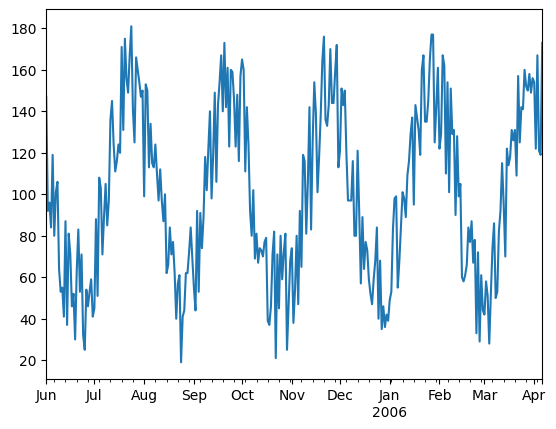

In [16]:
bikes['Berri 1'].plot()

Next up, we're just going to look at the Berri bike path. Berri is a street in Montreal, with a pretty important bike path. I use it mostly on my way to the library now, but I used to take it to work sometimes when I worked in Old Montreal.

So we're going to create a dataframe with just the Berri bikepath in it

In [17]:
berri_bikes = bikes[['Berri 1']].copy()

In [18]:
berri_bikes[:5]

,Berri 1
2005-06-01,147
2005-06-02,92
2005-06-03,96
2005-06-04,84
2005-06-05,119


Next, we need to add a 'weekday' column. Firstly, we can get the weekday from the index. We haven't talked about indexes yet, but the index is what's on the left on the above dataframe, under 'Date'. It's basically all the days of the year.

In [19]:
berri_bikes.index

DatetimeIndex(['2005-06-01', '2005-06-02', '2005-06-03', '2005-06-04',
               '2005-06-05', '2005-06-06', '2005-06-07', '2005-06-08',
               '2005-06-09', '2005-06-10',
               ...
               '2006-03-28', '2006-03-29', '2006-03-30', '2006-03-31',
               '2006-04-01', '2006-04-02', '2006-04-03', '2006-04-04',
               '2006-04-05', '2006-04-06'],
              dtype='datetime64[ns]', length=310, freq=None)

You can see that actually some of the days are missing -- only 310 days of the year are actually there. Who knows why.

Pandas has a bunch of really great time series functionality, so if we wanted to get the day of the month for each row, we could do it like this:

In [20]:
berri_bikes.index.day

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
            ...
            28, 29, 30, 31,  1,  2,  3,  4,  5,  6],
           dtype='int64', length=310)

We actually want the weekday, though:

In [21]:
berri_bikes.index.weekday

Int64Index([2, 3, 4, 5, 6, 0, 1, 2, 3, 4,
            ...
            1, 2, 3, 4, 5, 6, 0, 1, 2, 3],
           dtype='int64', length=310)

These are the days of the week, where 0 is Monday. I found out that 0 was Monday by checking on a calendar.

Now that we know how to get the weekday, we can add it as a column in our dataframe like this:

In [22]:
berri_bikes.loc[:,'weekday'] = berri_bikes.index.weekday
berri_bikes[:5]

,Berri 1,weekday
2005-06-01,147,2
2005-06-02,92,3
2005-06-03,96,4
2005-06-04,84,5
2005-06-05,119,6


### Adding up the cyclists by weekday

This turns out to be really easy!

Dataframes have a `.groupby()` method that is similar to SQL groupby, if you're familiar with that. I'm not going to explain more about it right now -- if you want to to know more, the [documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html) is really good.

In this case, `berri_bikes.groupby('weekday').aggregate(sum)` means "Group the rows by weekday and then add up all the values with the same weekday".

In [23]:
weekday_counts = berri_bikes.groupby('weekday').aggregate(sum)
weekday_counts

,Berri 1
weekday,
0,4495
1,4490
2,4535
3,4407
4,4353
5,4435
6,4417


It's hard to remember what 0, 1, 2, 3, 4, 5, 6 mean, so we can fix it up and graph it:

In [24]:
# weekday_counts.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# weekday_counts

<AxesSubplot: xlabel='weekday'>

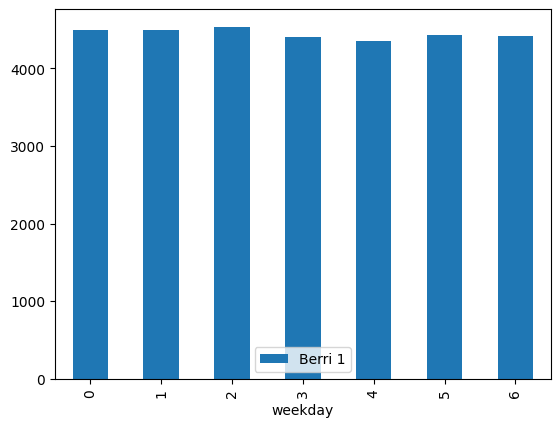

In [25]:
weekday_counts.plot(kind='bar')

So it looks like Montrealers are commuter cyclists -- they bike much more during the week. Neat!

### Putting it together

Now we want to request the full code execution.

Let's put all that together, to prove how easy it is. 6 lines of magical pandas!

If you want to play around, try changing sum to max, numpy.median, or any other function you like.

In [26]:
# Todo, fix indexes in function

In [27]:
@sy.syft_function(input_policy=sy.ExactMatch(bikes=asset.mock),
                  output_policy=sy.SingleExecutionExactOutput())
def get_bike_hist(bikes):
    berri_bikes = bikes[['Berri 1']].copy()
    berri_bikes.loc[:,'weekday'] = berri_bikes.index.weekday
    weekday_counts = berri_bikes.groupby('weekday').aggregate(sum)
    return weekday_counts

Request code execution

In [28]:
req = guest_domain_client.api.services.code.request_code_execution(get_bike_hist)

In [29]:
submitted_code = guest_domain_client.code[0]

In [30]:
assert guest_domain_client.api.services.code.get_all()

Create and submit project

In [31]:
new_project = sy.Project(name="Pandas Chapter 4",
                         description="Hi, I would like to plot histogram of bikers per weekday")

In [32]:
new_project.add_request(obj=submitted_code, permission=sy.UserCodeStatus.EXECUTE)

In [33]:
guest_domain_client.submit_project(new_project)

<class 'syft.core.node.new.response.SyftSuccess'>: Project Submitted

# Data owner: execute syft_function

In [34]:
from syft import Worker, MessageStatus
from syft.core.node.new.project import Project

# Get messages

In [36]:
root_domain_client = worker.root_client

In [37]:
messages = root_domain_client.api.services.messages.get_all_for_status(MessageStatus.UNDELIVERED)

In [38]:
messages

,type,id,subject,status,created_at,linked_obj
0,syft.core.node.new.messages.Message,8b50589635b540cc8f458479d325325c,Project Approval,MessageStatus.UNDELIVERED,2023-05-15 12:08:58,<<class 'syft.core.node.new.project.Project'>:...
1,syft.core.node.new.messages.Message,95eca3f1b0fa4c519d4e82822227f0f4,Approval Request,MessageStatus.UNDELIVERED,2023-05-15 12:08:58,<<class 'syft.core.node.new.request.Request'>:...


In [39]:
project_message = [x for x in messages if issubclass(x.linked_obj.object_type, Project)][0]

In [40]:
request = project_message.link.requests[0]
func = request.changes[0].link
op = func.output_policy_type

In [41]:
func

```python
class UserCode:
  id: str = e67f50b49d684cfebbb59d20820fe199
  node_uid: str = 7bca415d13ed1ec841f0d0aede098dbb
  user_verify_key: str = 8fe7341d1563267e8cf45ec091e039827b3d1b9c16d5a0d80090adde33a7aaf8
  raw_code: str = "@sy.syft_function(input_policy=sy.ExactMatch(bikes=asset.mock),
                  output_policy=sy.SingleExecutionExactOutput())
def get_bike_hist(bikes):
    berri_bikes = bikes[['Berri 1']].copy()
    berri_bikes.loc[:,'weekday'] = berri_bikes.index.weekday
    weekday_counts = berri_bikes.groupby('weekday').aggregate(sum)
    return weekday_counts
"
  input_policy_type: str = <class 'syft.core.node.new.policy.ExactMatch'>
  input_policy_init_kwargs: str = {NodeView(node_name='test-domain-1', verify_key=aec6ea4dfc049ceacaeeebc493167a88a200ddc367b1fa32da652444b635d21f): {'bikes': <UID: 0afde236da924bc489b33d826201257d>}}
  input_policy_state: str = b''
  output_policy_type: str = <class 'syft.core.node.new.policy.OutputPolicyExecuteOnce'>
  output_policy_init_kwargs: str = {}
  output_policy_state: str = b''
  parsed_code: str = "

def user_func_get_bike_hist_8fe7341d1563267e8cf45ec091e039827b3d1b9c16d5a0d80090adde33a7aaf8_8d8256c2fdc5571401947971c192627c1969ce527c7715d90da86fa9f28c9558(bikes):

    def get_bike_hist(bikes):
        berri_bikes = bikes[['Berri 1']].copy()
        berri_bikes.loc[(:, 'weekday')] = berri_bikes.index.weekday
        weekday_counts = berri_bikes.groupby('weekday').aggregate(sum)
        return weekday_counts
    result = get_bike_hist(bikes=bikes)
    return result
"
  service_func_name: str = "get_bike_hist"
  unique_func_name: str = "user_func_get_bike_hist_8fe7341d1563267e8cf45ec091e039827b3d1b9c16d5a0d80090adde33a7aaf8_8d8256c2fdc5571401947971c192627c1969ce527c7715d90da86fa9f28c9558"
  user_unique_func_name: str = "user_func_get_bike_hist_8fe7341d1563267e8cf45ec091e039827b3d1b9c16d5a0d80090adde33a7aaf8"
  code_hash: str = "8d8256c2fdc5571401947971c192627c1969ce527c7715d90da86fa9f28c9558"
  signature: str = (bikes)
  status: str = {NodeView(node_name='test-domain-1', verify_key=aec6ea4dfc049ceacaeeebc493167a88a200ddc367b1fa32da652444b635d21f): <UserCodeStatus.SUBMITTED: 'submitted'>}
  input_kwargs: str = ['bikes']
  enclave_metadata: str = None

```

In [42]:
get_col_user_function = func.unsafe_function

In [44]:
real_data = root_domain_client.datasets[0].assets[0].data

In [45]:
real_result = get_col_user_function(bikes=real_data)

In [46]:
bikes=real_data
berri_bikes = bikes[['Berri 1']].copy()
berri_bikes.loc[:,'weekday'] = berri_bikes.index.weekday
weekday_counts = berri_bikes.groupby('weekday').aggregate(sum)
real_result = weekday_counts

In [47]:
real_result[:3]

,Berri 1
weekday,
0,134298
1,135305
2,152972


In [48]:
result = request.accept_by_depositing_result(real_result)
result
assert isinstance(result, sy.SyftSuccess)

# Data scientist: fetch result

In [49]:
guest_domain_client = worker.guest_client
guest_client = guest_domain_client.login(email="jane@caltech.edu", password="abc123")

In [50]:
asset = guest_client.datasets[0].assets[0]

In [51]:
guest_client.api.services.code[0].status

{NodeView(node_name='test-domain-1', verify_key=aec6ea4dfc049ceacaeeebc493167a88a200ddc367b1fa32da652444b635d21f): <UserCodeStatus.EXECUTE: 'execute'>}

<AxesSubplot: xlabel='weekday'>

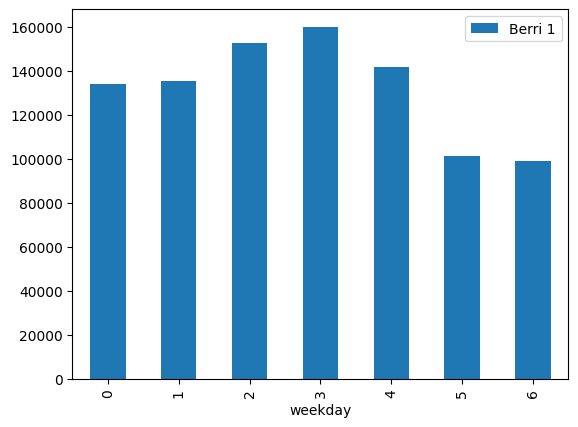

In [52]:
real_result = guest_client.api.services.code.get_bike_hist(bikes=asset)
real_result.plot(kind="bar")